In [74]:
# Librerias necesarias (version python trabajado 3.10.9) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
from sklearn.linear_model import LinearRegression

In [75]:
archivo_excel = 'PRUEBA_MODELOS_RIESGOS.xlsx'

hojas = pd.read_excel(archivo_excel, sheet_name=None)
for nombre_hoja, datos in hojas.items():
    globals()[nombre_hoja] = datos
# Nombre de los DF: VARIACION_MENSUAL, VARIACION_TRIMESTRE, SERIE_OBJETIVO, TASAS_DE_CETES

# Convertir las fechas de SERIE OBJETIVO
SERIE_OBJETIVO['Fecha'] = pd.to_datetime(
    SERIE_OBJETIVO['Fecha'], format='%b %Y', errors='coerce'
)

# Convertir las fechas de SERIES EXTERNAS
VARIACION_MENSUAL['Fecha'] = pd.to_datetime(
    VARIACION_MENSUAL['Fecha'], format='%b %Y', errors='coerce'
)

# Verificar que no haya valores nulos después de la conversión
if SERIE_OBJETIVO['Fecha'].isnull().any() or VARIACION_MENSUAL['Fecha'].isnull().any():
    print("Algunas fechas no se pudieron convertir. Revisa el formato.")


#### Calculo SERIE OBETIVO (IMORA)

In [76]:
serie_objetivo = SERIE_OBJETIVO.sort_values(by='Fecha')
serie_objetivo['IMORA_YoY'] = serie_objetivo['Índice de Morosidad (IMORA)'].pct_change(periods=12) * 100 # Revisar periodos a revisar segun instrucciones 


In [77]:
# Definir los límites inferior y superior para detectar outliers
Q1 = serie_objetivo['IMORA_YoY'].quantile(0.25)
Q3 = serie_objetivo['IMORA_YoY'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = serie_objetivo[(serie_objetivo['IMORA_YoY'] < lower_bound) | (serie_objetivo['IMORA_YoY'] > upper_bound)]  # Detectar outliers
print('Outliears detectados', outliers)


Outliears detectados         Fecha  Índice de Morosidad (IMORA)  IMORA_YoY
43 2007-07-01                     4.259983  46.152052
44 2007-08-01                     4.334365  44.939596
45 2007-09-01                     4.473663  48.950559
46 2007-10-01                     4.652233  53.865054
47 2007-11-01                     4.788354  54.988594
48 2007-12-01                     5.030441  67.869268
49 2008-01-01                     5.142946  61.041561
50 2008-02-01                     5.263942  57.524669
51 2008-03-01                     5.232231  49.647820
52 2008-04-01                     5.503238  48.557772
63 2009-03-01                     7.557839  44.447732
64 2009-04-01                     7.990597  45.198100
65 2009-05-01                     8.419149  49.158295
66 2009-06-01                     8.607025  51.143813
67 2009-07-01                     8.667510  48.351820
68 2009-08-01                     8.844459  48.714654


In [78]:
# Transformación logarítmica para reducir el impacto de los outliers
serie_objetivo['IMORA_YoY_log'] = np.log1p(serie_objetivo['Índice de Morosidad (IMORA)'])


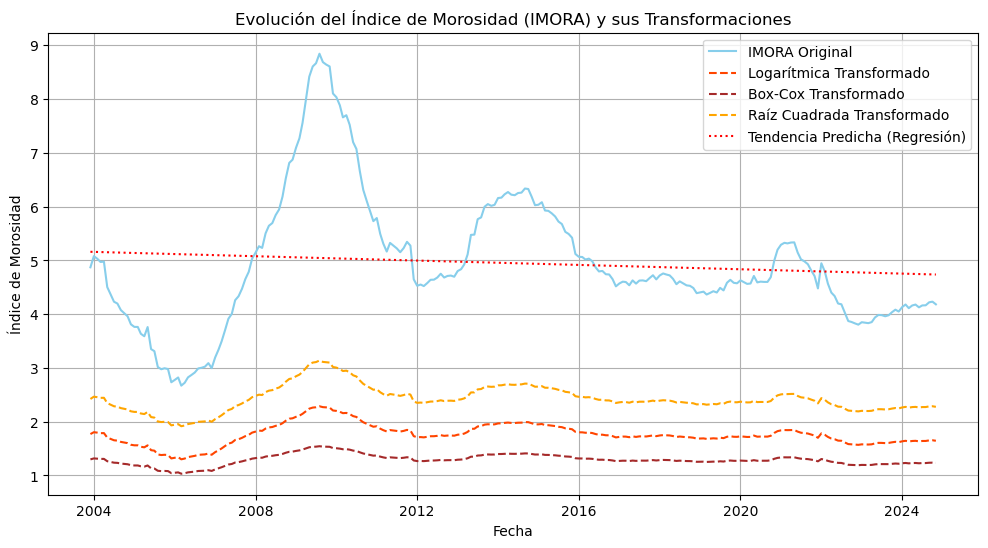

In [79]:

# Asegurarse de que 'Fecha' esté en formato numérico (por ejemplo, número de días desde el inicio)
serie_objetivo['Fecha_numerica'] = (serie_objetivo['Fecha'] - serie_objetivo['Fecha'].min()).dt.days

# Transformación Logarítmica
serie_objetivo['IMORA_YoY_log'] = np.log1p(serie_objetivo['Índice de Morosidad (IMORA)'])

# Transformación Box-Cox
serie_objetivo['IMORA_YoY_boxcox'], lambda_ = stats.boxcox(serie_objetivo['Índice de Morosidad (IMORA)'] + 1)  # Asegúrate de que no haya ceros o valores negativos

# Raíz cuadrada
serie_objetivo['IMORA_YoY_sqrt'] = np.sqrt(serie_objetivo['Índice de Morosidad (IMORA)'] + 1)

# linea de Tendencia 
X = serie_objetivo[['Fecha_numerica']]
y = serie_objetivo['Índice de Morosidad (IMORA)']
model = LinearRegression().fit(X, y)
serie_objetivo['IMORA_Predicho'] = model.predict(X)


plt.figure(figsize=(12, 6))

plt.plot(serie_objetivo['Fecha'], serie_objetivo['Índice de Morosidad (IMORA)'], label="IMORA Original", color="skyblue") # IMORA original
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_YoY_log'], label="Logarítmica Transformado", color="orangered", linestyle='--') # IMORA transformado Logarítmica
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_YoY_boxcox'], label="Box-Cox Transformado", color="brown", linestyle='--') # IMORA transformado Box-Cox
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_YoY_sqrt'], label="Raíz Cuadrada Transformado", color="orange", linestyle='--')# IMORA transformado Raíz Cuadrada
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_Predicho'], label="Tendencia Predicha (Regresión)", color="red", linestyle=':')# IMORA Tendencia

plt.title("Evolución del Índice de Morosidad (IMORA) y sus Transformaciones")
plt.xlabel("Fecha")
plt.ylabel("Índice de Morosidad")
plt.legend()
plt.grid()

plt.show()



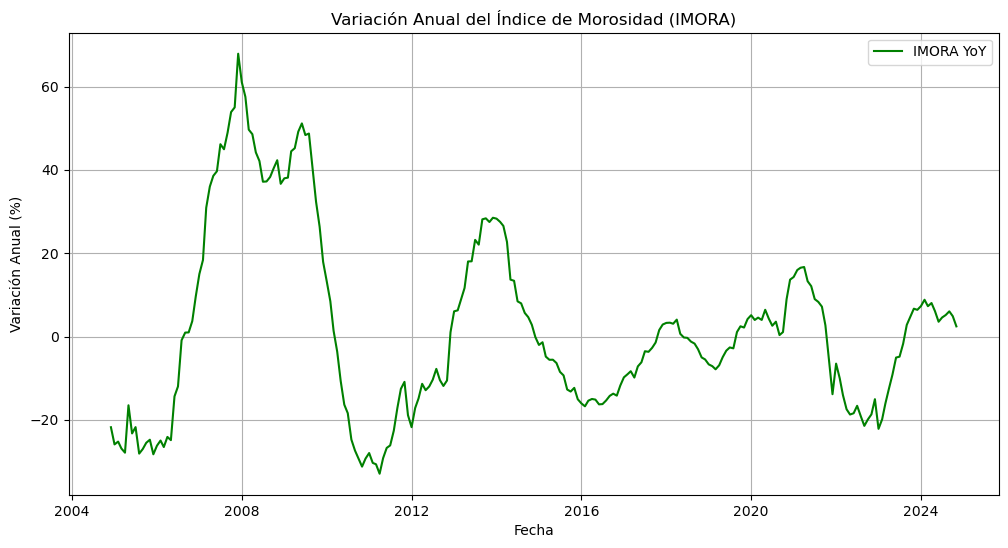

In [80]:
plt.figure(figsize=(12, 6))
plt.plot(serie_objetivo['Fecha'], serie_objetivo['IMORA_YoY'], label="IMORA YoY", color="green")
plt.title("Variación Anual del Índice de Morosidad (IMORA)")
plt.xlabel("Fecha")
plt.ylabel("Variación Anual (%)")
plt.legend()
plt.grid()
plt.show()

#### Relacion con Variables externas

In [96]:
serie_objetivo

,Fecha,Índice de Morosidad (IMORA),IMORA_YoY,IMORA_YoY_log,Fecha_numerica,IMORA_YoY_boxcox,IMORA_YoY_sqrt,IMORA_Predicho
0,2003-12-01,4.872023,NaN,1.770199,0,1.299305,2.423226,5.160431
1,2004-01-01,5.078869,NaN,1.804819,31,1.317190,2.465536,5.158716
2,2004-02-01,5.031642,NaN,1.797019,62,1.313181,2.455940,5.157001
3,2004-03-01,4.971209,NaN,1.786949,91,1.307987,2.443606,5.155397
4,2004-04-01,4.977101,NaN,1.787936,122,1.308497,2.444811,5.153682
...,...,...,...,...,...,...,...,...
247,2024-07-01,4.162985,4.557524,1.641515,7518,1.230781,2.272220,4.744563
248,2024-08-01,4.165305,5.150561,1.641964,7549,1.231026,2.272731,4.742848
249,2024-09-01,4.220420,6.037746,1.652578,7580,1.236801,2.284824,4.741133
250,2024-10-01,4.233011,4.874951,1.654987,7610,1.238109,2.287578,4.739474


In [81]:
datos_completos = pd.merge(serie_objetivo, VARIACION_MENSUAL, on='Fecha', how='inner')

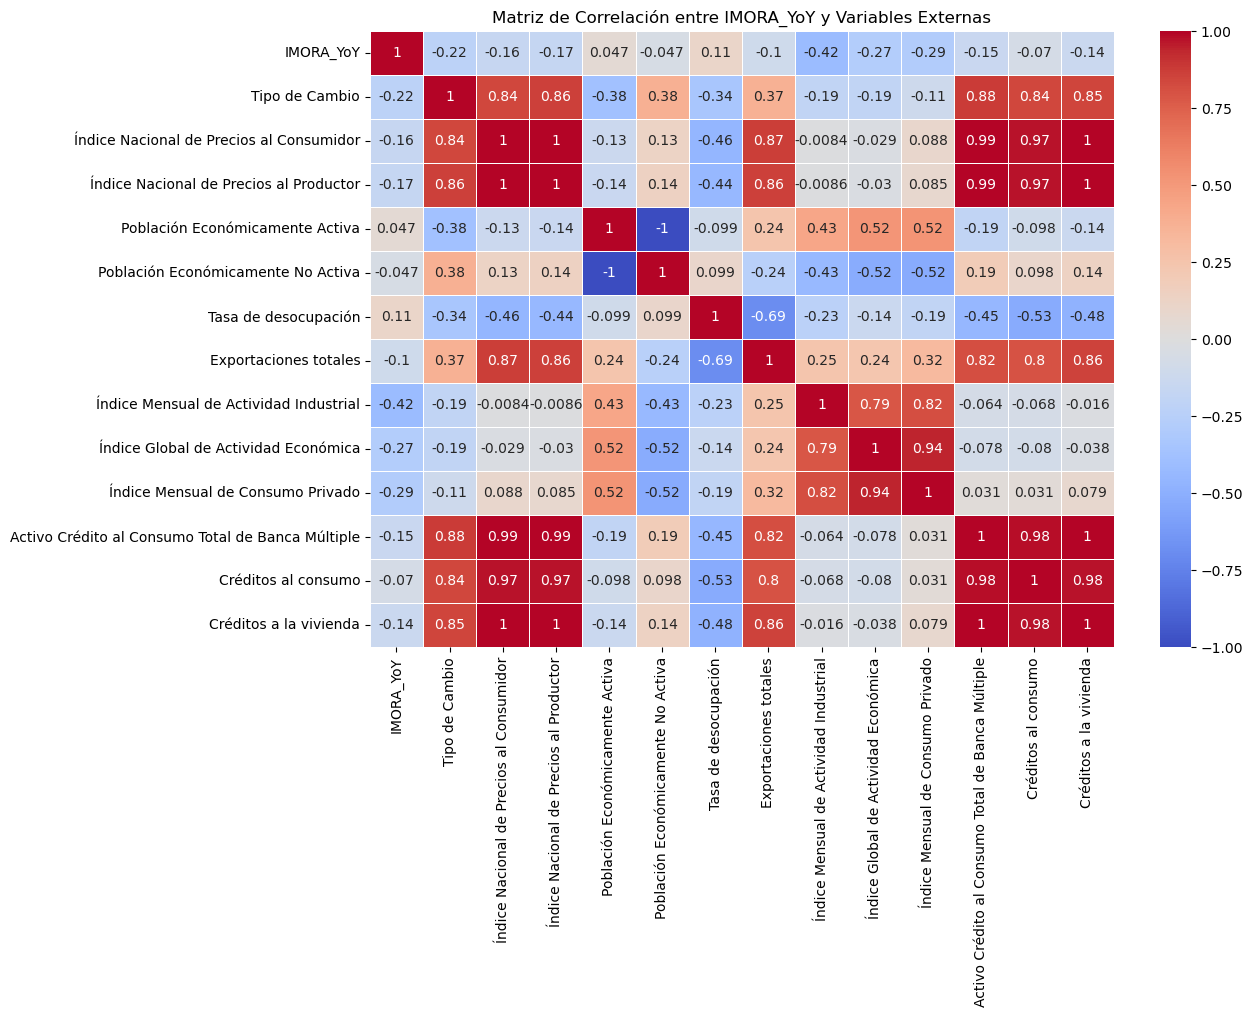

In [95]:
# Calculamos la correlación entre las variables explicativas y la serie IMORA_YoY
correlacion = datos_completos[['IMORA_YoY', 'Tipo de Cambio', 'Índice Nacional de Precios al Consumidor', 
                               'Índice Nacional de Precios al Productor', 'Población Económicamente Activa', 
                               'Población Económicamente No Activa', 'Tasa de desocupación', 'Exportaciones totales', 
                               'Índice Mensual de Actividad Industrial', 'Índice Global de Actividad Económica', 
                               'Índice Mensual de Consumo Privado', 'Activo Crédito al Consumo Total de Banca Múltiple', 
                               'Créditos al consumo', 'Créditos a la vivienda']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Matriz de Correlación entre IMORA_YoY y Variables Externas")
plt.show()


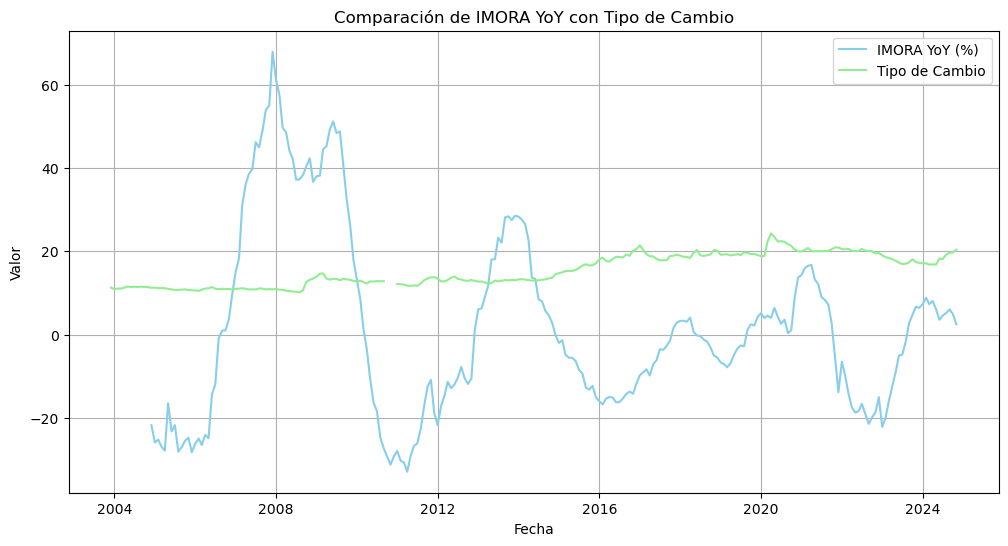

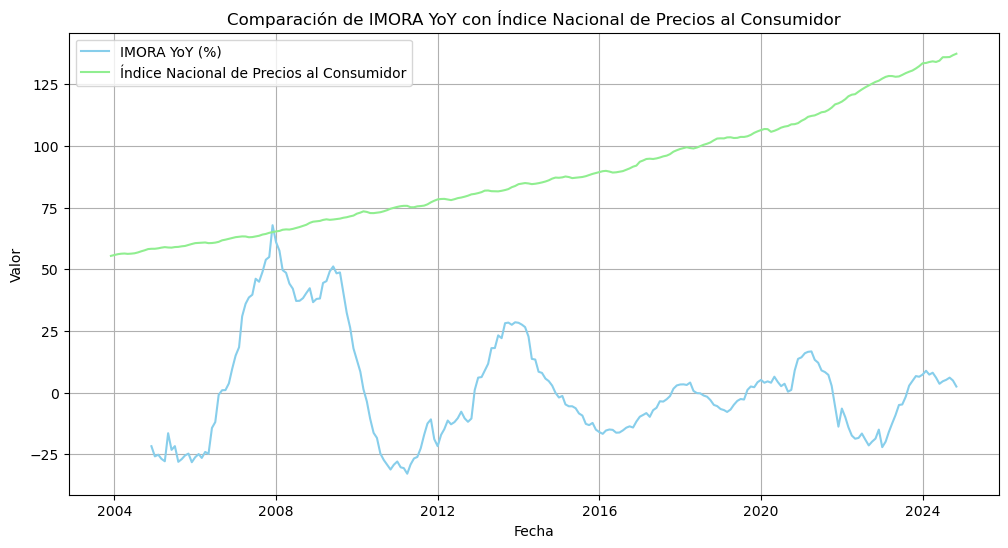

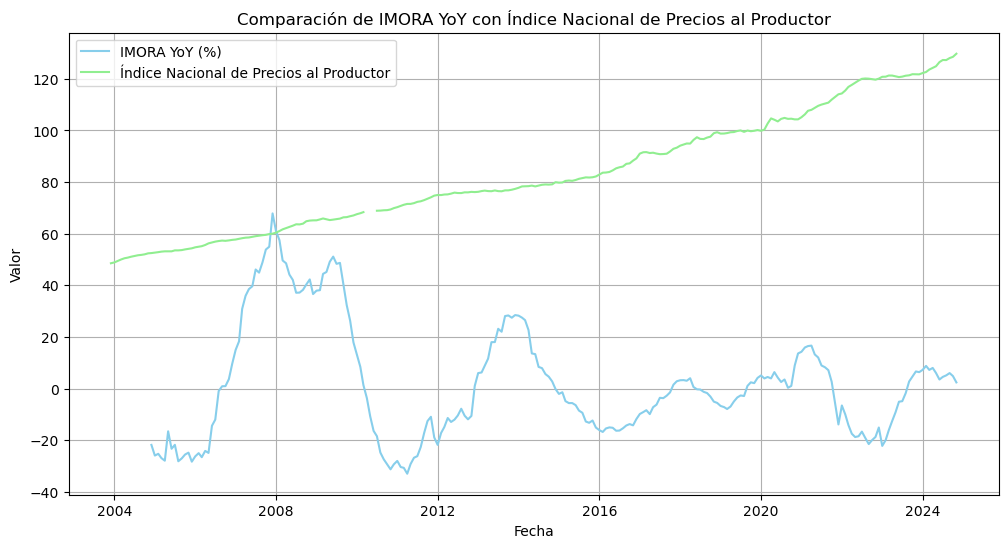

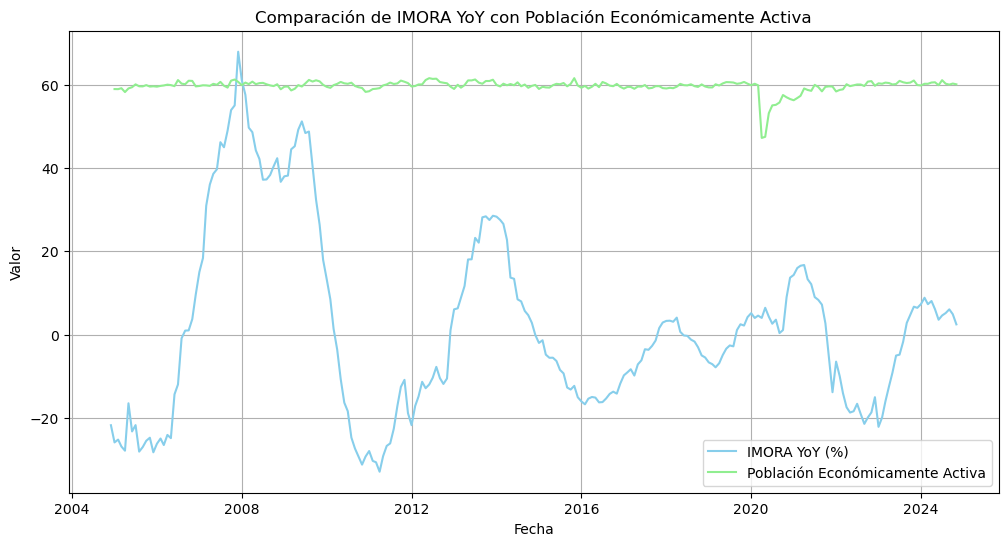

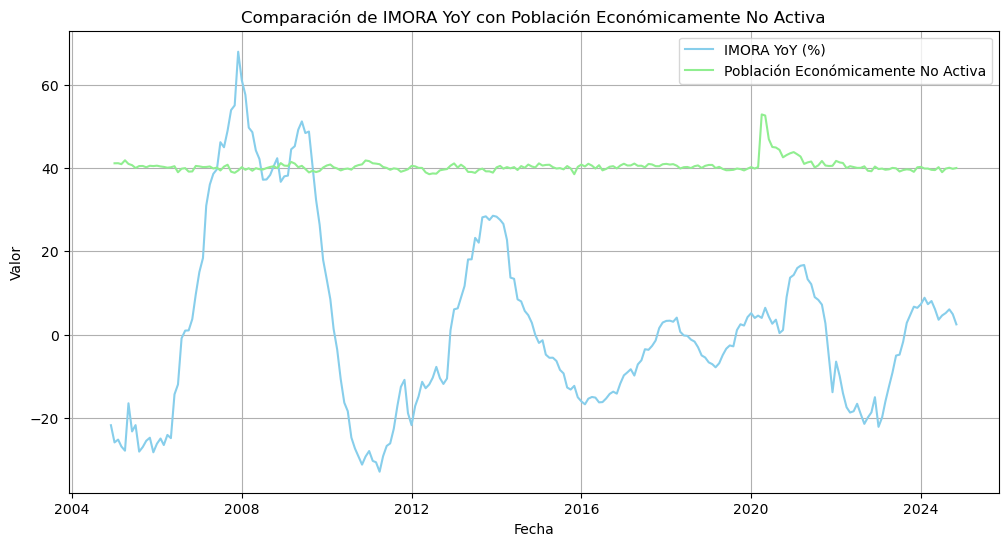

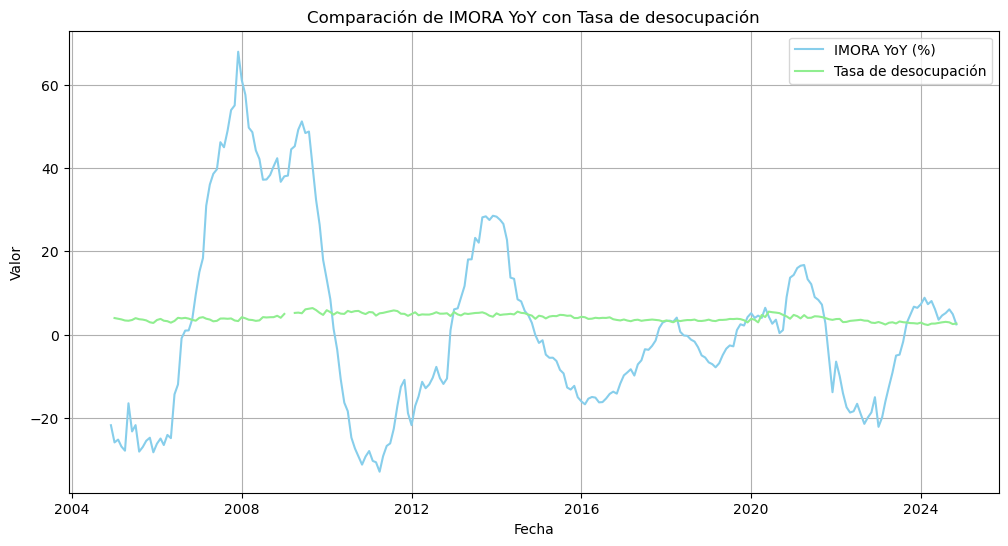

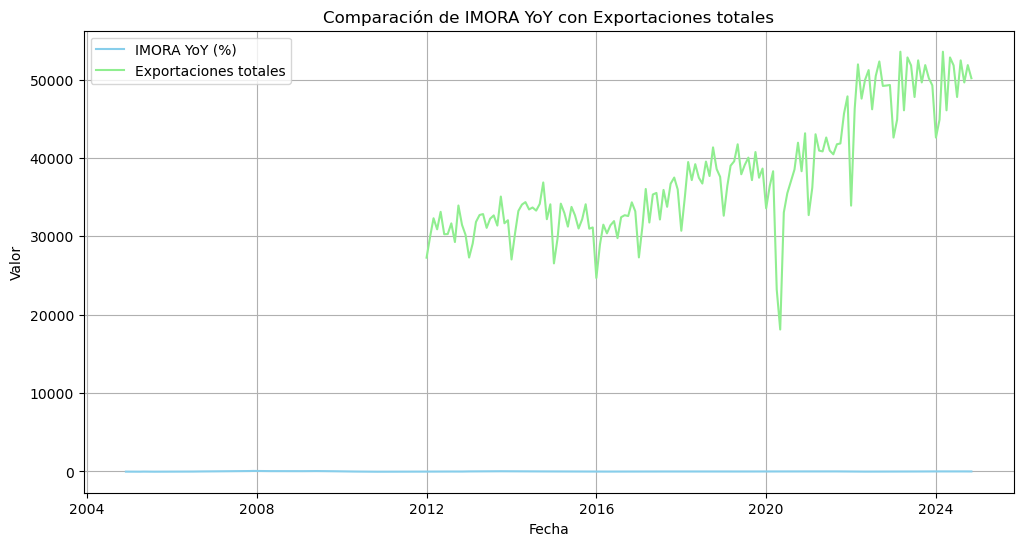

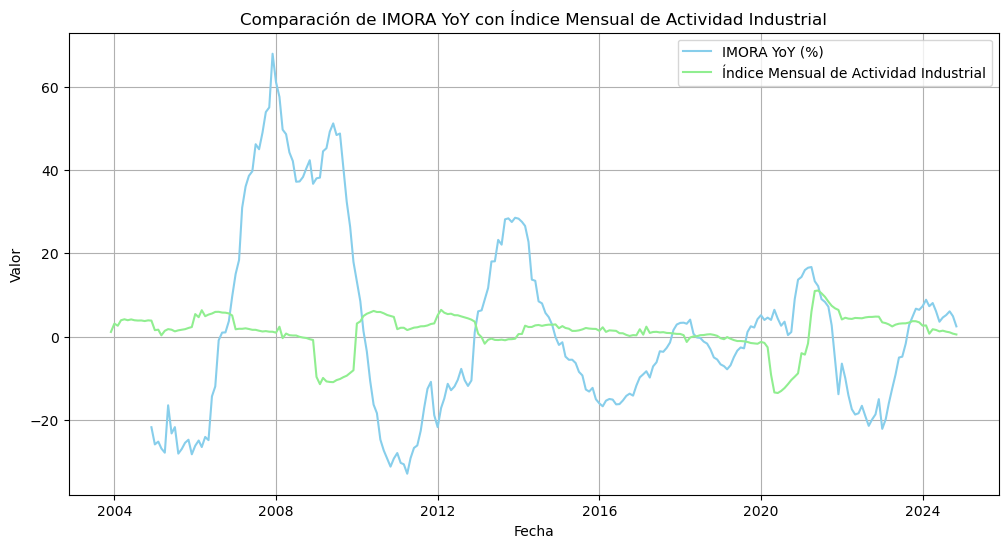

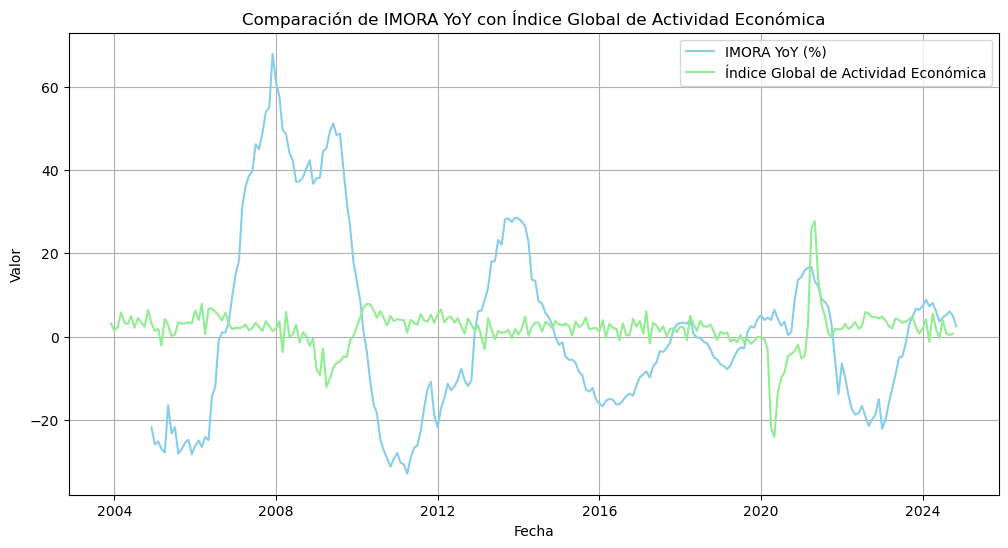

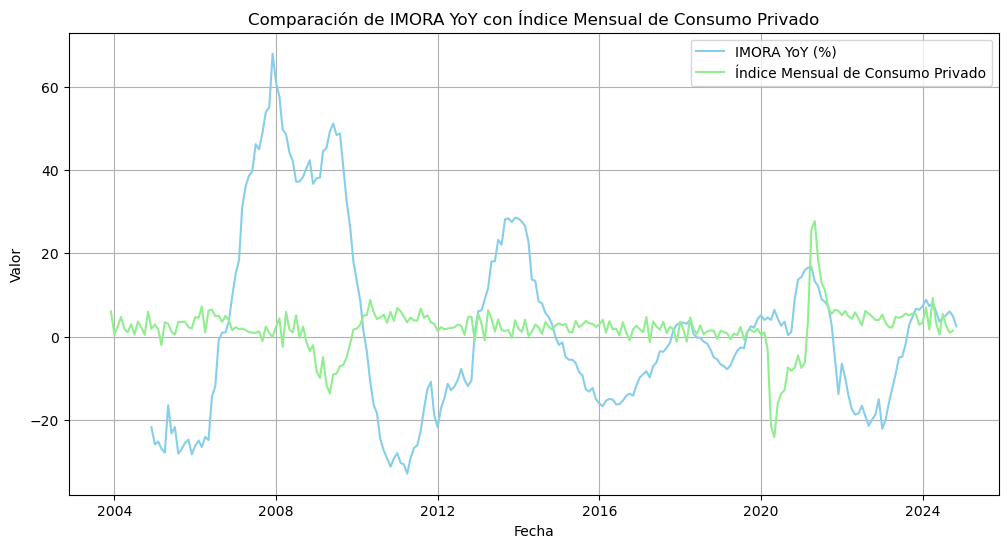

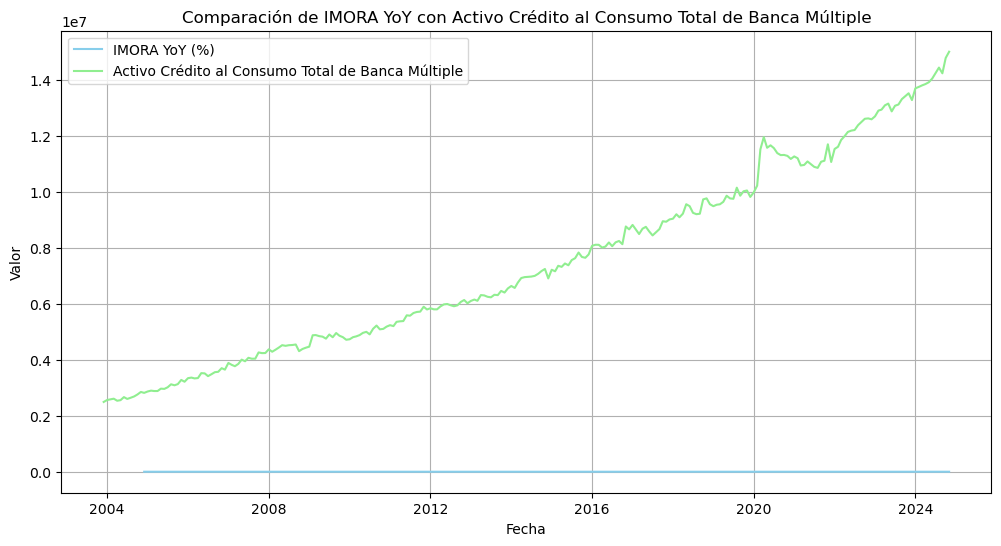

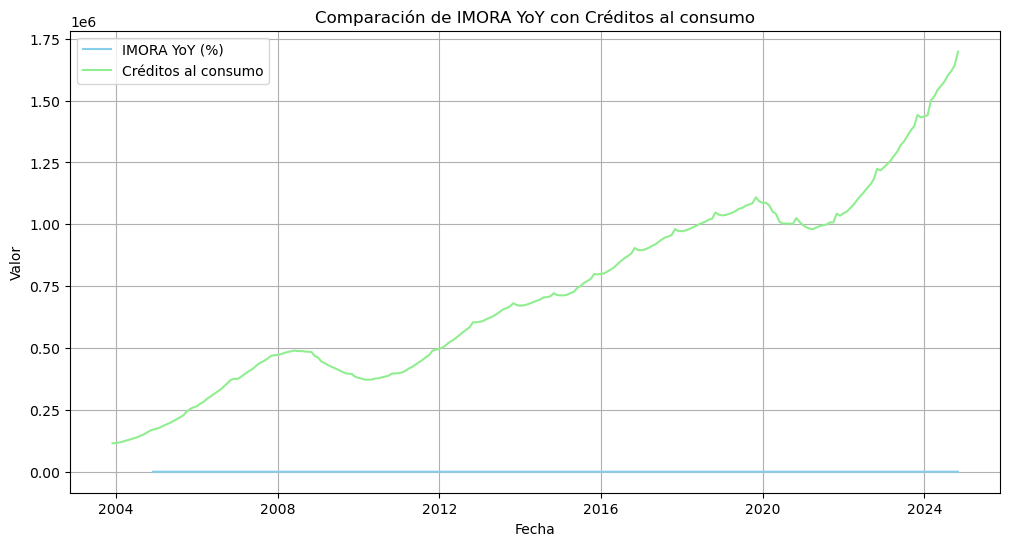

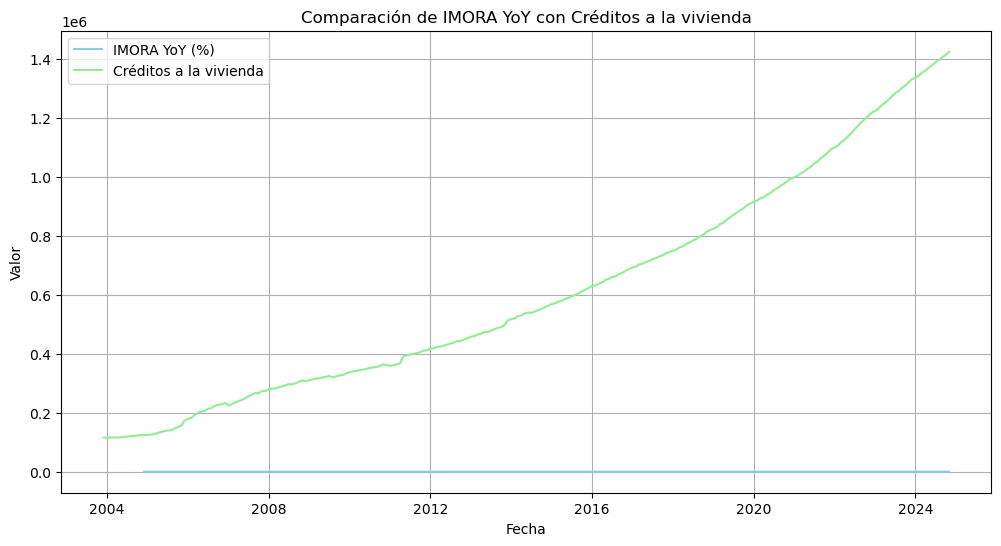

In [90]:
# Lista de las columnas de SERIES EXTERNAS que queremos comparar
serie_externas = [
    "Tipo de Cambio",
    "Índice Nacional de Precios al Consumidor",
    "Índice Nacional de Precios al Productor",
    "Población Económicamente Activa",
    "Población Económicamente No Activa",
    "Tasa de desocupación",
    "Exportaciones totales",
    "Índice Mensual de Actividad Industrial",
    "Índice Global de Actividad Económica",
    "Índice Mensual de Consumo Privado",
    "Activo Crédito al Consumo Total de Banca Múltiple",
    "Créditos al consumo",
    "Créditos a la vivienda"
]

# Graficar IMORA_YoY junto con cada variable externa
for variable in serie_externas:
    plt.figure(figsize=(12, 6))
    
    # Graficar IMORA_YoY
    plt.plot(datos_completos['Fecha'], datos_completos['IMORA_YoY'], label="IMORA YoY (%)", color="skyblue")
    
    # Graficar la variable externa
    plt.plot(datos_completos['Fecha'], datos_completos[variable], label=variable, color="lightgreen")
    
    # Configurar el gráfico
    plt.title(f"Comparación de IMORA YoY con {variable}")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid()
    plt.show()


In [91]:
# Calcular correlaciones de IMORA_YoY con cada variable externa
correlaciones = datos_completos.corr()["IMORA_YoY"].drop("IMORA_YoY")

# Ordenar las correlaciones por magnitud (de mayor a menor)
correlaciones = correlaciones.sort_values(ascending=False)

# Mostrar las correlaciones
print("Correlaciones de IMORA YoY con variables externas:")
print(correlaciones)


Correlaciones de IMORA YoY con variables externas:
Índice de Morosidad (IMORA)                          0.439146
IMORA_YoY_sqrt                                       0.435650
IMORA_YoY_log                                        0.430242
IMORA_YoY_boxcox                                     0.425063
IMORA_Predicho                                       0.164223
Tasa de desocupación                                 0.105606
Población Económicamente Activa                      0.047391
Población Económicamente No Activa                  -0.047391
Créditos al consumo                                 -0.069617
Exportaciones totales                               -0.101673
Créditos a la vivienda                              -0.138119
Activo Crédito al Consumo Total de Banca Múltiple   -0.145930
Índice Nacional de Precios al Consumidor            -0.159890
Fecha_numerica                                      -0.164223
Índice Nacional de Precios al Productor             -0.171598
Tipo de Cambio     

C:\Users\humberto.ortiz\AppData\Local\Temp\ipykernel_22148\2917478742.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlaciones = datos_completos.corr()["IMORA_YoY"].drop("IMORA_YoY")


#### ARIMA Predecir proximos dos años 